Description: This script creates Figure 11, a two panel plot with one subplot showing the histogram of total and CG flash flash rates in the Edmond-Carney storm. The second subplot shows application of lightning jump algorithm as per Schultz et al. (2015)

In [1]:
import glob
import math
import os
import sys
import warnings
from datetime import datetime, timedelta

import matplotlib
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import netCDF4 as ncdf
import numpy as np
import pandas as pd
import pyart
import tables
import xarray as xr
from matplotlib import colors
from matplotlib.colorbar import Colorbar
from netCDF4 import Dataset, date2num, num2date
# from numpy import *
from numpy import ones, vstack
from numpy.linalg import lstsq
from pyart.graph import common

from lmatools.vis.multiples_nc import centers_to_edges

from may19_2013_obs_analysis.lma_parsing import time2sec, bbox_lma_data

warnings.filterwarnings("ignore")

# set run command parameters for matplotlib plots
matplotlib.rc("xtick", labelsize=21)
matplotlib.rc("ytick", labelsize=21)


plt.rcParams["figure.figsize"] = [20, 8]
plt.rcParams["font.size"] = 15
plt.rcParams["xtick.labelsize"] = 25
plt.rcParams["ytick.labelsize"] = 25
plt.rcParams["axes.labelsize"] = 25
plt.rcParams["legend.fontsize"] = 20
plt.rcParams["legend.markerscale"] = 2


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
h5files = sorted(
    glob.glob(
        os.path.expanduser(
            "../data/processed/OKLMA_h5_files/*.h5"
        )
    )
)
h5files = h5files[0:15]

flash_rate = []
all_flash_len = []
flash_rate_4 = []
ratio = []
xticklab = []

for f in h5files:
    h5 = tables.open_file(f)
    event_table = getattr(
        h5.root.events,
        f"LMA_{f.split('/')[-1].split('_')[1]}"
        + "_"
        + f"{f.split('/')[-1].split('_')[2]}"
        + "_600",
    )

    flash_table = getattr(
        h5.root.flashes,
        f"LMA_{f.split('/')[-1].split('_')[1]}"
        + "_"
        + f"{f.split('/')[-1].split('_')[2]}"
        + "_600",
    )

    ll_lon, ul_lon, ll_lat, ul_lat = bbox_lma_data(int(f.split("/")[-1][14:20]))

    intervals = time2sec(f)
    xtick = f.split("/")[-1][14:18]
    xticklab.append(xtick)
    for i in range(10):

        interval_left, interval_right = next(intervals)

        mask = (flash_table.cols.start[:] > interval_left) & (
            flash_table.cols.start[:] <= interval_right
        )
        selected = flash_table[mask]

        selected = selected[
            (selected["init_lon"] > ll_lon) & (selected["init_lon"] < ul_lon)
        ]
        selected = selected[
            (selected["init_lat"] > ll_lat) & (selected["init_lat"] < ul_lat)
        ]

        # excluding flashes with zero duration and less than 10 sources (this might just be noise)
        selected = selected[selected["duration"] != 0]
        selected = selected[selected["n_points"] >= 10]

        area = selected["area"]
        length = np.sqrt(area)
        m_length = np.mean(length)
        all_flash_len.append(m_length)
        flash_rate.append(len(selected))

In [3]:
# Lightning Jump Algorithm for OKLMA total lightning data

two_min_avg = [(a + b) / 2 for a, b in zip(flash_rate[::2], flash_rate[1::2])]

lja_res = []
threshold = []
DFRDT = []
for i in range(len(two_min_avg)):
    if (two_min_avg[i] >= 10) & (i >= 6):
        prior_avg = two_min_avg[i - 6 : i]
        dfrdt = [(b - a) / 2 for a, b in zip(prior_avg, prior_avg[1:])]
        std = np.std(dfrdt)
        thresh = 2 * std
        threshold.append(thresh)
        dfrdt.append((two_min_avg[i] - two_min_avg[i - 1]) / 2)
        DFRDT.append(dfrdt[-1])

        if dfrdt[-1] > thresh:
            lja = "Yes"
            res = (i, lja)

        else:
            lja = "No"
            res = (i, lja)

    else:
        lja = "No"
        res = (i, lja)
        threshold.append(0)
        DFRDT.append(np.nan)

    lja_res.append(res)


idx_lja = [x for x, y in enumerate(lja_res) if y[1] == "Yes"]

lja_DFRDT = []
for i in idx_lja:
    tmp = DFRDT[i]
    lja_DFRDT.append(tmp)


tims = pd.date_range("2013-05-19 20:02:00", "2013-05-19 22:30:00", freq="2min").time
tims_f = []
for i in range(len(tims)):
    tims_f.append(tims[i].strftime("%H%M"))

Due to proprietary issues, we cannot share high-resolution NLDN data. Interested readers may contact Vaisala (owners of NLDN data)

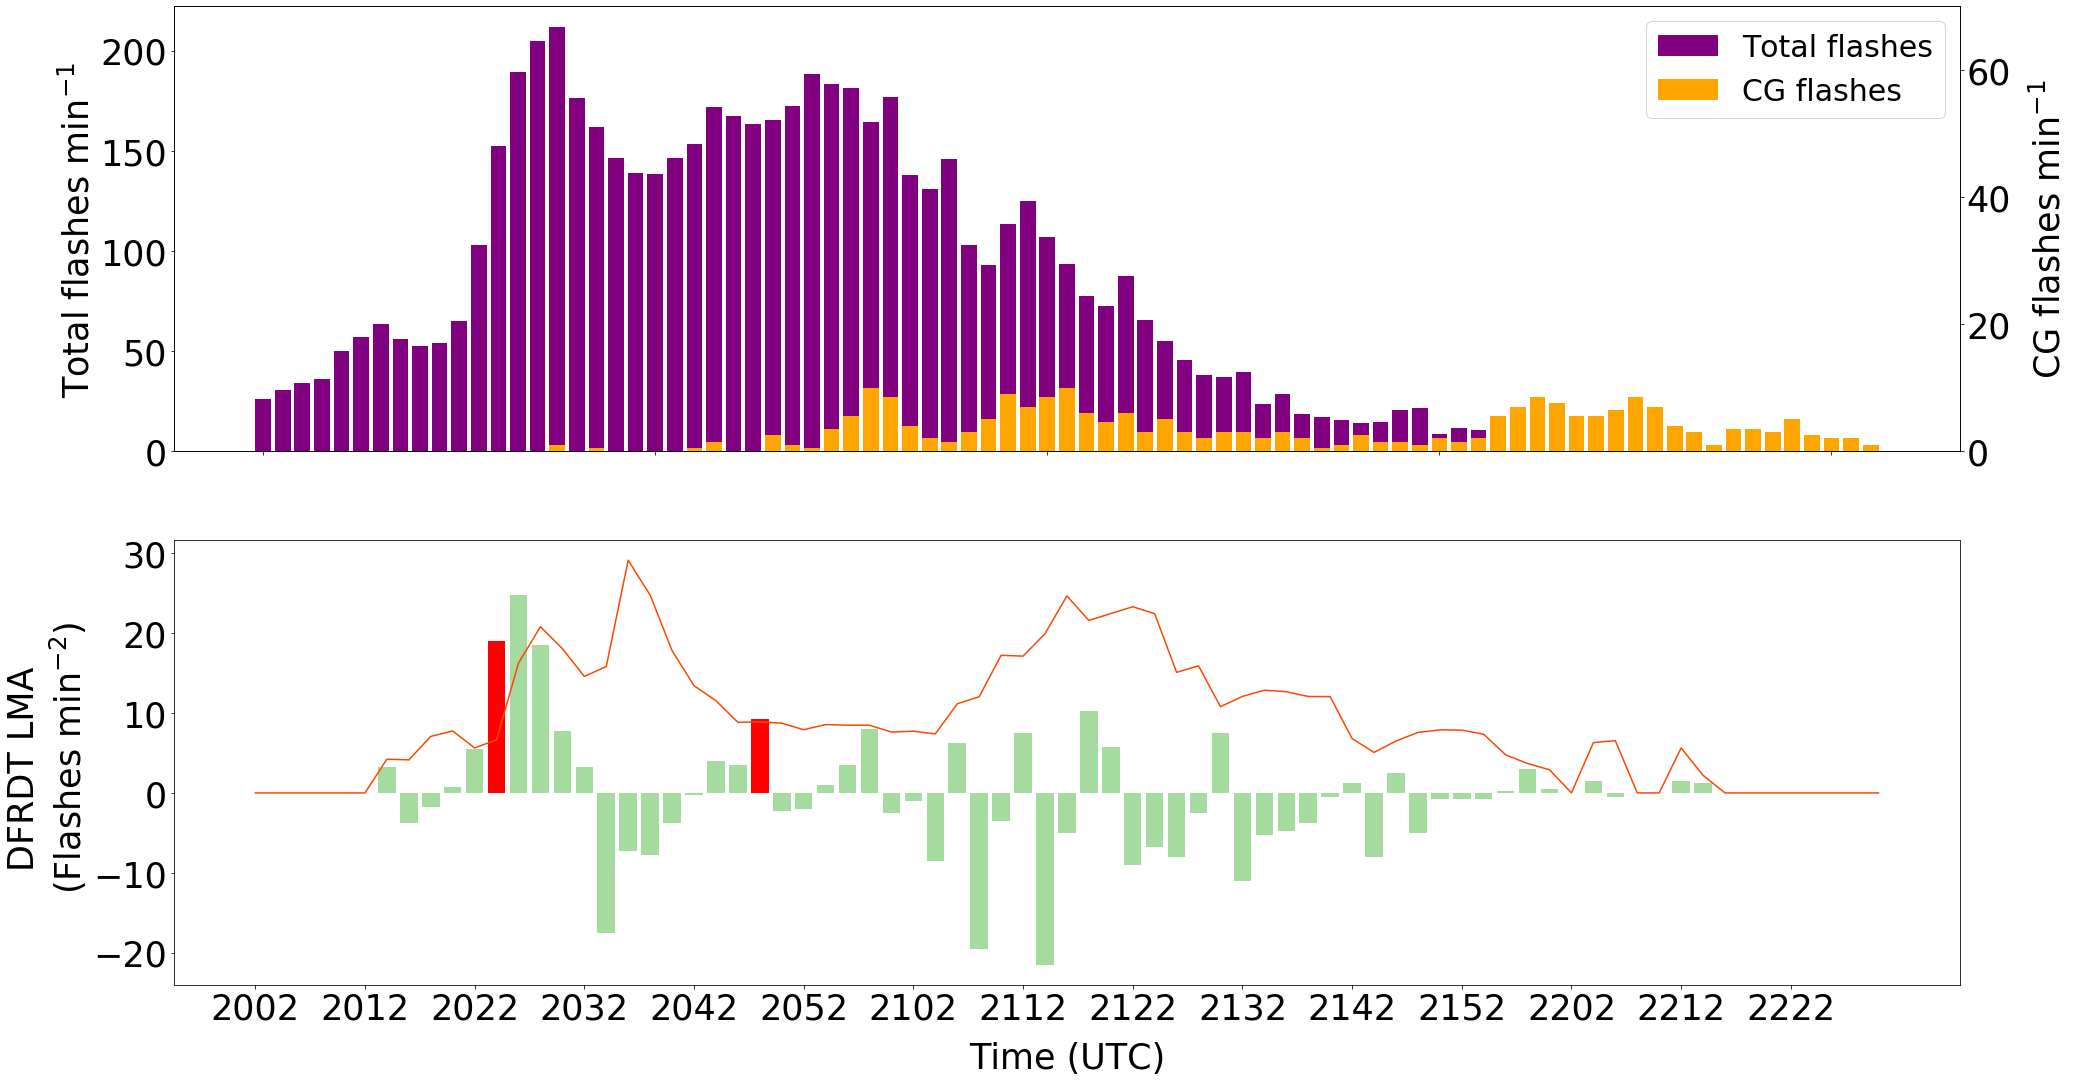

In [4]:
# load 1 minute binned NLDN CG flash rates 
total1 = pd.read_csv('../data/processed/nldn_data/nldn_1min_cg_flash_rates.csv',index_col=0)

cg_fr = total1.iloc[:, 0].values

add = []
for i in range(15):
    add.append(0)

cg_frt = add

for i in range(len(cg_fr)):
    cg_frt.append(cg_fr[i])

cg_two_min_avg = [(a + b) / 2 for a, b in zip(cg_frt[::2], cg_frt[1::2])]

plt.rcParams["xtick.labelsize"] = 35
plt.rcParams["ytick.labelsize"] = 35
plt.rcParams["axes.labelsize"] = 35
plt.rcParams["legend.fontsize"] = 30

fig, ax = plt.subplots(2, 1, figsize=(32, 18))
ax[0].bar(
    np.arange(0, 75, 1),
    two_min_avg,
    align="center",
    color="purple",
    label="Total flashes",
)
ax[0].tick_params(axis="x", labelbottom=False)
ax[0].set_ylabel("Total flashes min$^{-1}$")

ax2 = ax[0].twinx()
ax2.bar(
    np.arange(0, 83, 1),
    cg_two_min_avg,
    align="center",
    color="orange",
    label="CG flashes",
)
ax2.set_ylim(0, 70)
ax2.set_ylabel("CG flashes min$^{-1}$", labelpad=20)
ax[0].bar(np.arange(0, 75, 1), np.nan, color="orange", label="CG flashes")
ax[0].legend(loc=0)

ax[1].plot(threshold, color="orangered")
ax[1].bar(np.arange(0, 75, 1), DFRDT, align="center", color="#a6dba0")
ax[1].bar(idx_lja[0::2], lja_DFRDT[0::2], align="center", color="r")
ax[1].set_xticks(np.arange(0, 75, 5))
ax[1].set_xticklabels(tims_f[::5])
ax[1].set_ylabel("DFRDT LMA \n (Flashes min$^{-2}$)")
ax[1].set_xlabel("Time (UTC)", labelpad=15)

plt.show()

### New method, same plot

In [5]:
def check_lja_valid(dtidx,two_min_avg,df):
    
    from datetime import timedelta
    """
    This function applies the 45 minute lead time warning rule
    for lightning jump algorithm (Schultz et al. 2011). If a lightning jump was triggered
    at time t = t0, then the next one can only be triggered at time
    t = t0 + 45 or later.
    
    Input:
    ------
    dtidx : Datetime Index corresponding to initally identified LJs
    
    Returns:
    ------
    valid lightning jump datetime indices from current time
    """
    df1 = df.copy()
    lja_idx = two_min_avg.loc[dtidx[dtidx].index] > 10
    df1.loc[lja_idx.index[lja_idx['sum']].tolist(), 'LJA cls'] = 'Y'
    
    return df1

In [6]:
tims = pd.date_range("2013-05-19 20:01:00", "2013-05-19 22:30:00", freq="1min")
tims_f = []
for i in range(len(tims)):
    tims_f.append(tims[i].strftime("%H%M"))

final_data_lma = pd.DataFrame(flash_rate,columns=['sum'],index=tims)
final_data_lma

,sum
2013-05-19 20:01:00,30
2013-05-19 20:02:00,22
2013-05-19 20:03:00,32
2013-05-19 20:04:00,29
2013-05-19 20:05:00,31
...,...
2013-05-19 22:26:00,5
2013-05-19 22:27:00,3
2013-05-19 22:28:00,2
2013-05-19 22:29:00,1


### NOTE: We don't include the second trigger in case DFRDT exceeds consecutive 2$\sigma$

In [7]:
# # aggregate CG flashes by seconds
# total = final_data.index.value_counts().sort_index()

# # binning the aggregated CG counts above into 1 minute bins for calculatinf flash rates (CG/min)
# total1 = total.resample("Min",label='right').agg({'sum'})

two_min_avg_lma = final_data_lma.resample('2T',label='right',closed='right').mean()
a_lma = (two_min_avg_lma.resample('2T').last().diff())/2

b_lma = a_lma.rolling(window=5,).apply(lambda x: np.nanstd(x))
b_lma = b_lma.shift(periods=1)
two_sigma_lma = 2*b_lma

lja_lma = (a_lma >= two_sigma_lma)

a_lma = pd.DataFrame(a_lma)
a_lma['LJA cls'] = 'N'

tt_lma = check_lja_valid(lja_lma['sum'],two_min_avg_lma,a_lma)

### Let's try LJA on NLDN total lightning data

In [18]:
# Due to proprietary issues we cannot share raw NLDN data files. Interested readers may contact Vaisala for direct access.

# load processed 1 minute binned data for total CG NLDN flash rates 
total1_nldn = pd.read_csv('../data/processed/nldn_data/nldn_1min_high_res_total_cg_flash_rates.csv',index_col=0)
total1_nldn.index = pd.to_datetime(total1_nldn.index)

In [19]:
two_min_avg_nldn = total1_nldn.resample('2T',label='right',closed='right').mean()
a_nldn = (two_min_avg_nldn.resample('2T').last().diff())/2
a_nldn.head(10)

,sum
2013-05-19 20:14:00,NaN
2013-05-19 20:16:00,0.25
2013-05-19 20:18:00,0.25
2013-05-19 20:20:00,-0.50
2013-05-19 20:22:00,-0.25
2013-05-19 20:24:00,0.25
2013-05-19 20:26:00,0.25
2013-05-19 20:28:00,-0.50
2013-05-19 20:30:00,0.50
2013-05-19 20:32:00,0.00


In [20]:
b_nldn = a_nldn.rolling(window=5,).apply(lambda x: np.nanstd(x))
b_nldn = b_nldn.shift(periods=1)
two_sigma_nldn = 2*b_nldn

In [21]:
from datetime import timedelta

lja_nldn = (a_nldn >= two_sigma_nldn)

In [22]:
a_nldn = pd.DataFrame(a_nldn)
a_nldn['LJA cls'] = 'N'

tt_nldn = check_lja_valid(lja_nldn['sum'],two_min_avg_nldn,a_nldn)
tt_nldn

,sum,LJA cls
2013-05-19 20:14:00,NaN,N
2013-05-19 20:16:00,0.25,N
2013-05-19 20:18:00,0.25,N
2013-05-19 20:20:00,-0.50,N
2013-05-19 20:22:00,-0.25,N
...,...,...
2013-05-19 22:22:00,0.75,N
2013-05-19 22:24:00,-2.25,N
2013-05-19 22:26:00,0.00,N
2013-05-19 22:28:00,0.75,N


### Finally, plotting NLDN and LMA based lightning jumps

In [23]:
tt_lma.loc['2013-05-19 20:26:00','LJA cls'] = 'N'

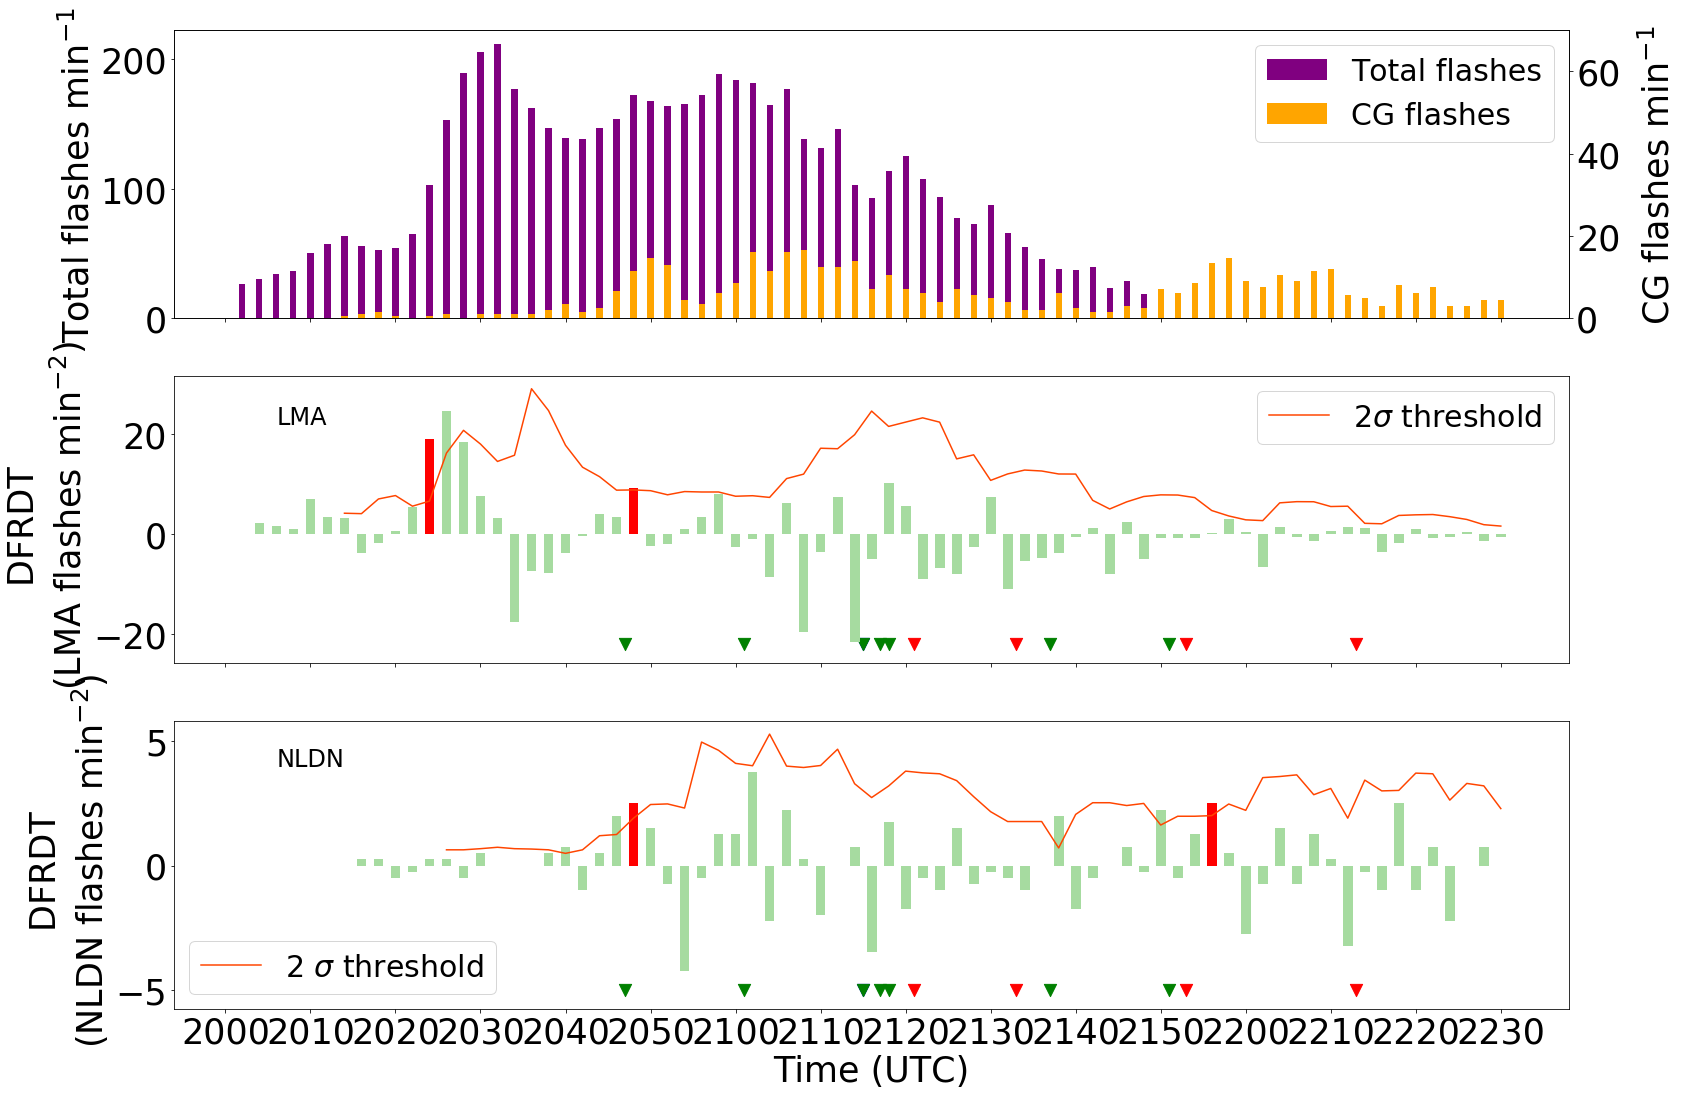

In [24]:
colors = {'N': '#a6dba0', 'Y': 'r'}

add_nldn = pd.date_range('2013-05-19 20:02:00','2013-05-19 20:12:00',freq='2Min')

fig, ax = plt.subplots(3,1,figsize=(25, 18),sharex=True,)

# Total lightning flash rates ----------------------------------------------

ax[0].bar(x = two_min_avg_lma.index,
          width=0.0005,
          height = two_min_avg_lma['sum'],
          color='purple',
          label="Total flashes",)

# ax[0].tick_params(axis="x", labelbottom=False)
ax[0].set_ylabel("Total flashes min$^{-1}$")


ax2 = ax[0].twinx()
two_min_avg_nldn = pd.DataFrame(two_min_avg_nldn,two_min_avg_nldn.index.union(add_nldn))
two_min_avg_nldn.loc['2013-05-19 20:02:00':'2013-05-19 20:12:00','sum'] = 0

ax2.bar(x = two_min_avg_nldn.index,
       width=0.0005,
       height = two_min_avg_nldn['sum'],
       color='orange',
       label="CG flashes",)

ax2.set_ylim(0, 70)
ax2.set_ylabel("CG flashes min$^{-1}$", labelpad=20)

ax[0].xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0, 10, 20, 30, 40, 50]))
ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%H%M"))
ax[0].tick_params(axis='x',labelrotation=0)

ax[0].bar(np.arange(0, 75, 1), np.nan, color="orange", label="CG flashes")
ax[0].legend(loc=0)

# LMA LJA plot----------------------------------------------


color_list_lma = [colors[i] for i in tt_lma['LJA cls']]
ax[1].bar(x = tt_lma.index,
           width = 0.0008,
           height = tt_lma['sum'],
           color=color_list_lma)


# Set title and labels for axes
ax[1].set(xlabel=" ",
       ylabel="DFRDT \n (LMA flashes min$^{-2}$)",
       title=" ")

ax[1].plot(two_sigma_lma,color='orangered',label='2$\sigma$ threshold')

# Define the date format
ax[1].xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0, 10, 20, 30, 40, 50]))
ax[1].xaxis.set_major_formatter(mdates.DateFormatter("%H%M"))
ax[1].tick_params(axis='x',labelrotation=0)

ax[1].tick_params(axis="x", labelbottom=False)
ax[1].annotate('LMA',xy=(datetime(2013,5,19,20,6,0),22),
               xycoords="data",
               textcoords="offset points",
               xytext = (0,0),
               fontsize=24,
              )

ax[1].legend()
# add wind reports on x-axis (these reports were obtained from SPC storm reports archive)
ax[1].scatter(datetime(2013, 5, 19, 21, 15, 0), -22, marker='v', s=150, c='b')

# add hail reports on x-axis (these reports were obtained from SPC storm reports archive)
ax[1].scatter(datetime(2013, 5, 19, 20, 47, 0), -22, marker='v', s=150, c='g')
ax[1].scatter(datetime(2013, 5, 19, 21, 1, 0), -22, marker='v', s=150, c='g')
ax[1].scatter(datetime(2013, 5, 19, 21, 15, 0), -22, marker='v', s=150, c='g')
ax[1].scatter(datetime(2013, 5, 19, 21, 17, 0), -22, marker='v', s=150, c='g')
ax[1].scatter(datetime(2013, 5, 19, 21, 18, 0), -22, marker='v', s=150, c='g')
ax[1].scatter(datetime(2013, 5, 19, 21, 37, 0), -22, marker='v', s=150, c='g')
ax[1].scatter(datetime(2013, 5, 19, 21, 51, 0), -22, marker='v', s=150, c='g')

# add tornado reports on x-axis (these reports were obtained from SPC storm reports archive)
ax[1].scatter(datetime(2013, 5, 19, 21, 21, 0), -22, marker='v', s=150, c='r')
ax[1].scatter(datetime(2013, 5, 19, 21, 33, 0), -22, marker='v', s=150, c='r')
ax[1].scatter(datetime(2013, 5, 19, 21, 53, 0), -22, marker='v', s=150, c='r')
ax[1].scatter(datetime(2013, 5, 19, 22, 13, 0), -22, marker='v', s=150, c='r')

# NLDN LJA plot ----------------------------------------------

tt_nldn = pd.DataFrame(tt_nldn,tt_nldn.index.union(add_nldn))
tt_nldn.loc['2013-05-19 20:02:00':'2013-05-19 20:12:00','LJA cls'] = 'N'
tt_nldn.loc['2013-05-19 20:02:00':'2013-05-19 20:12:00','sum'] = 0

color_list_nldn = [colors[i] for i in tt_nldn['LJA cls']]

ax[2].bar(x = tt_nldn.index,
           width = 0.0008,
           height = tt_nldn['sum'],
           color=color_list_nldn)

# Set title and labels for axes
ax[2].set(xlabel="Time (UTC)",
       ylabel="DFRDT \n (NLDN flashes min$^{-2}$)",
       title=" ")

two_sigma_nldn = pd.DataFrame(two_sigma_nldn,two_sigma_nldn.index.union(add_nldn))

ax[2].annotate('NLDN',xy=(datetime(2013,5,19,20,6,0),4),
               xycoords="data",
               textcoords="offset points",
               xytext = (0,0),
               fontsize=24,
              )
ax[2].plot(two_sigma_nldn,color='orangered',label='2 $\sigma$ threshold')

# Define the date format
ax[2].xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0, 10, 20, 30, 40, 50]))
ax[2].xaxis.set_major_formatter(mdates.DateFormatter("%H%M"))
ax[2].tick_params(axis='x',labelrotation=0)


ax[2].legend()

# add wind reports on x-axis (these reports were obtained from SPC storm reports archive)
ax[2].scatter(datetime(2013, 5, 19, 21, 15, 0), -5, marker='v', s=150, c='b')

# add hail reports on x-axis (these reports were obtained from SPC storm reports archive)
ax[2].scatter(datetime(2013, 5, 19, 20, 47, 0), -5, marker='v', s=150, c='g')
ax[2].scatter(datetime(2013, 5, 19, 21, 1, 0), -5, marker='v', s=150, c='g')
ax[2].scatter(datetime(2013, 5, 19, 21, 15, 0), -5, marker='v', s=150, c='g')
ax[2].scatter(datetime(2013, 5, 19, 21, 17, 0), -5, marker='v', s=150, c='g')
ax[2].scatter(datetime(2013, 5, 19, 21, 18, 0), -5, marker='v', s=150, c='g')
ax[2].scatter(datetime(2013, 5, 19, 21, 37, 0), -5, marker='v', s=150, c='g')
ax[2].scatter(datetime(2013, 5, 19, 21, 51, 0), -5, marker='v', s=150, c='g')

# add tornado reports on x-axis (these reports were obtained from SPC storm reports archive)
ax[2].scatter(datetime(2013, 5, 19, 21, 21, 0), -5, marker='v', s=150, c='r')
ax[2].scatter(datetime(2013, 5, 19, 21, 33, 0), -5, marker='v', s=150, c='r')
ax[2].scatter(datetime(2013, 5, 19, 21, 53, 0), -5, marker='v', s=150, c='r')
ax[2].scatter(datetime(2013, 5, 19, 22, 13, 0), -5, marker='v', s=150, c='r')

# ax[1].tick_params(axis="x", labelbottom=False)
# plt.savefig('/Users/ms/Desktop/mount/May_19_2013_all_stuff/plots_LMA_May19_2013/manuscript_figures/final_png_files/LightningJump.png',
#             dpi=300,bbox_inches='tight')
plt.show()